In [1]:
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
%matplotlib inline

ticker= "googl"
stock_data = yf.download(ticker, start="2016-01-04", end="2021-05-12")

[*********************100%***********************]  1 of 1 completed


In [2]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,762.200012,762.200012,747.539978,759.440002,759.440002,3369100
2016-01-05,764.099976,769.200012,755.650024,761.530029,761.530029,2260800
2016-01-06,750.369995,765.729980,748.000000,759.330017,759.330017,2410300
2016-01-07,746.489990,755.309998,735.280029,741.000000,741.000000,3156600
2016-01-08,747.799988,750.119995,728.919983,730.909973,730.909973,2375300


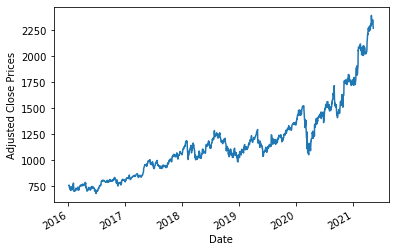

In [3]:
stock_data['Adj Close'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

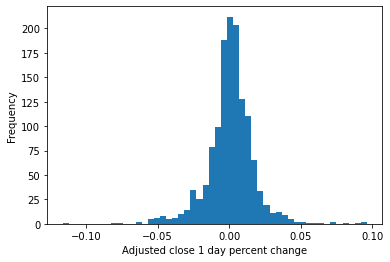

In [4]:
stock_data['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel("Adjusted close 1 day percent change")
plt.show()

In [5]:
feature_names = []
for n in [14, 30, 50, 200]:
    stock_data['ma' + str(n)] = talib.SMA(stock_data['Adj Close'].values, timeperiod=n)
    stock_data['rsi' + str(n)] = talib.RSI(stock_data['Adj Close'].values, timeperiod=n)

    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

In [6]:
stock_data['Volume_1d_change'] = stock_data['Volume'].pct_change()

volume_features = ['Volume_1d_change']
feature_names.extend(volume_features)

In [7]:
stock_data['5d_future_close'] = stock_data['Adj Close'].shift(-5)
stock_data['5d_close_future_pct'] = stock_data['5d_future_close'].pct_change(5)

In [14]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,Volume_1d_change,5d_future_close,5d_close_future_pct
Date,,,,,,,,,,,,,,,,,
2016-10-18,814.210022,828.809998,813.330017,821.489990,821.489990,2289300,806.243574,62.410490,803.949003,59.383942,802.204001,57.346334,754.359951,52.295207,1.167077,828.549988,0.008594
2016-10-19,822.880005,829.799988,822.880005,826.840027,826.840027,1500100,807.972146,65.148070,804.577338,60.791305,802.591202,58.185180,754.686501,52.484215,-0.344734,822.099976,-0.005733
2016-10-20,827.559998,828.469971,820.549988,821.630005,821.630005,1393900,809.227147,60.525277,805.203670,58.740830,802.854003,57.069885,754.998000,52.281481,-0.070795,817.349976,-0.005209
2016-10-21,820.000000,824.289978,818.309998,824.059998,824.059998,1615800,810.918575,61.883787,806.389671,59.401540,803.171202,57.457977,755.413300,52.367728,0.159194,819.559998,-0.005461
2016-10-24,830.090027,837.940002,829.039978,835.739990,835.739990,1447600,813.272147,67.647178,807.620337,62.395790,803.745002,59.264157,755.937451,52.780011,-0.104097,809.900024,-0.030919


In [8]:
stock_data.dropna(inplace=True)

X = stock_data[feature_names]
y = stock_data['5d_close_future_pct']

train_size = int(0.85 * y.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [10]:
grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [4, 8], 'random_state': [42]}
test_scores = []

rf_model = RandomForestRegressor()

for g in ParameterGrid(grid):
    rf_model.set_params(**g) 
    rf_model.fit(X_train, y_train)
    test_scores.append(rf_model.score(X_test, y_test))

best_index = np.argmax(test_scores)
print(test_scores[best_index], ParameterGrid(grid)[best_index])

0.0270902388930232 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


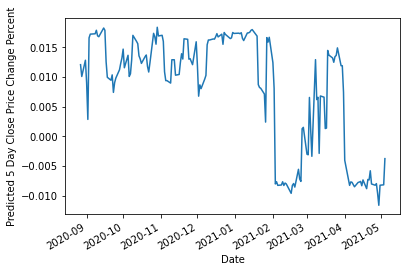

In [62]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

y_pred_series = pd.Series(y_pred, index=y_test.index)
y_pred_series.plot()
plt.ylabel("Predicted 5 Day Close Price Change Percent")
plt.show()

In [12]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.03131461182177225
Mean Squared Error: 0.0017425011780125114
Root Mean Squared Error: 0.04174327703969241


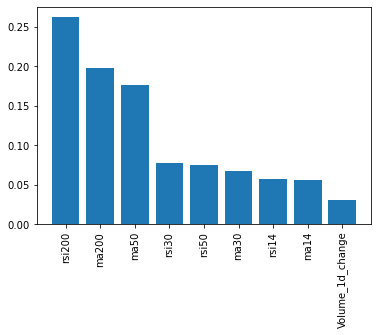

In [13]:
importances = rf_model.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x_values = range(len(importances))
labels = np.array(feature_names)[sorted_index]
plt.bar(x_values, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()